# Setup

In [1]:
# Define Parameters
batch_size = 128
epochs = 200
task = 'Disaster_Types_Classification'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import time
import torch
import torch.nn as nn
import torch.optim
import torchvision.models as models
import torchvision.transforms as transforms
import warnings
from PIL import Image
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

device = torch.device("cuda:0")
warnings.filterwarnings("ignore")

# Data Loading

In [3]:
dt_train_path = '/work/u9562361/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_train_final.tsv'
dt_test_path = '/work/u9562361/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_test_final.tsv'
dt_dev_path = '/work/u9562361/crisis_vision_benchmarks/tasks/disaster_types/consolidated/consolidated_disaster_types_dev_final.tsv'

train_label = pd.read_table(dt_train_path)
test_label = pd.read_table(dt_test_path)
dev_label = pd.read_table(dt_dev_path)

print(train_label.shape)
print(test_label.shape)
print(dev_label.shape)

(12846, 4)
(3195, 4)
(1470, 4)


In [4]:
class_label_map = {"landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0}

def get_data(pd_label, class_label_map):
    image_path = pd_label['image_path']
    class_label = pd_label['class_label']

    X, y, valid_indices = [], [], []

    tfms = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    for i in tqdm(range(len(image_path))):
        path = os.path.join('/work/u9562361/crisis_vision_benchmarks/', image_path[i])
        try:
            img = Image.open(path)
            if img is None:
                print(f"Error reading image: {path}")
                continue
            img = img.resize((224, 224))
            img = img.convert("RGB")
            img = np.array(img, dtype=np.float32) / 255.0
            img = tfms(img) 
            X.append(img)
            valid_indices.append(i)
        except Exception as e:
            print(f"Error opening image: {path} - {str(e)}")
            continue

    print(X[0].shape)
    X = np.stack(X)
    print(X.shape)

    for idx in tqdm(valid_indices):
        label = class_label[idx]
        if label not in class_label_map:
            print(f"Error: Unknown class label: {label}")
            continue
        y.append(class_label_map[label])

    y = np.array(y, dtype=np.int64)
    print(y.shape)

    return X, y

In [5]:
X_train, y_train = get_data(train_label, class_label_map)
X_test, y_test = get_data(test_label, class_label_map)
X_dev, y_dev = get_data(dev_label, class_label_map)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
trainset = TensorDataset(X_train, y_train)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)
testset = TensorDataset(X_test, y_test)

X_dev = torch.tensor(X_dev, dtype=torch.float32)
y_dev = torch.tensor(y_dev, dtype=torch.int64)
devset = TensorDataset(X_dev, y_dev)

100%|██████████| 12846/12846 [06:47<00:00, 31.53it/s]


torch.Size([3, 224, 224])
(12846, 3, 224, 224)


100%|██████████| 12846/12846 [00:00<00:00, 413872.79it/s]


(12846,)


100%|██████████| 3195/3195 [01:47<00:00, 29.81it/s]


torch.Size([3, 224, 224])
(3195, 3, 224, 224)


100%|██████████| 3195/3195 [00:00<00:00, 459230.36it/s]


(3195,)


100%|██████████| 1470/1470 [00:50<00:00, 28.85it/s]


torch.Size([3, 224, 224])
(1470, 3, 224, 224)


100%|██████████| 1470/1470 [00:00<00:00, 149571.27it/s]


(1470,)


In [6]:
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=4)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=4)
devloader = DataLoader(devset, batch_size=batch_size, shuffle=True, num_workers=4)

# ResNet50_pretrained

In [7]:
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [9]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [10]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.3693 - accuracy: 54.55% - val_loss: 0.9482 - val_accuracy: 71.36% - time: 46.44s
Epoch 2/100 - loss: 0.7893 - accuracy: 74.88% - val_loss: 0.7181 - val_accuracy: 76.93% - time: 46.18s
Epoch 3/100 - loss: 0.5734 - accuracy: 81.64% - val_loss: 0.6473 - val_accuracy: 78.22% - time: 46.05s
Epoch 4/100 - loss: 0.4197 - accuracy: 86.76% - val_loss: 0.6109 - val_accuracy: 79.97% - time: 46.17s
Epoch 5/100 - loss: 0.3015 - accuracy: 91.47% - val_loss: 0.6108 - val_accuracy: 79.62% - time: 46.31s
Epoch 6/100 - loss: 0.2052 - accuracy: 95.09% - val_loss: 0.6107 - val_accuracy: 80.31% - time: 46.29s
Epoch 7/100 - loss: 0.1337 - accuracy: 97.61% - val_loss: 0.6302 - val_accuracy: 80.09% - time: 46.13s
Epoch 8/100 - loss: 0.0863 - accuracy: 98.86% - val_loss: 0.6496 - val_accuracy: 80.13% - time: 46.22s
Epoch 9/100 - loss: 0.0573 - accuracy: 99.37% - val_loss: 0.6654 - val_accuracy: 80.16% - time: 46.08s
Epoch 10/100 - loss: 0.0401 - accuracy: 99.70% - val_loss: 0.6826 - val_a

Epoch 80/100 - loss: 0.0063 - accuracy: 99.97% - val_loss: 0.7619 - val_accuracy: 79.59% - time: 46.59s
Epoch 81/100 - loss: 0.0061 - accuracy: 99.98% - val_loss: 0.7582 - val_accuracy: 79.50% - time: 46.57s
Epoch 82/100 - loss: 0.0063 - accuracy: 99.96% - val_loss: 0.7616 - val_accuracy: 79.50% - time: 46.66s
Epoch 83/100 - loss: 0.0062 - accuracy: 99.98% - val_loss: 0.7572 - val_accuracy: 79.59% - time: 46.68s
Epoch 84/100 - loss: 0.0061 - accuracy: 99.98% - val_loss: 0.7556 - val_accuracy: 79.78% - time: 46.67s
Epoch 85/100 - loss: 0.0060 - accuracy: 99.98% - val_loss: 0.7614 - val_accuracy: 79.50% - time: 46.59s
Epoch 86/100 - loss: 0.0059 - accuracy: 99.98% - val_loss: 0.7616 - val_accuracy: 79.44% - time: 46.50s
Epoch 87/100 - loss: 0.0059 - accuracy: 99.98% - val_loss: 0.7582 - val_accuracy: 79.81% - time: 46.54s
Epoch 88/100 - loss: 0.0062 - accuracy: 99.97% - val_loss: 0.7644 - val_accuracy: 79.56% - time: 46.59s
Epoch 89/100 - loss: 0.0059 - accuracy: 99.98% - val_loss: 0.761

In [11]:
print(task + '_ResNet50_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_pretrained Classification Report:')
print(cr)

Disaster_Types_Classification_ResNet50_pretrained Performance:
Accuracy : 80.30%
F1-Score : 80.02%
Disaster_Types_Classification_ResNet50_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       990
           1       0.86      0.82      0.84       599
           2       0.83      0.81      0.82       404
           3       0.70      0.64      0.67       352
           4       0.87      0.89      0.88       280
           5       0.54      0.50      0.52       302
           6       0.78      0.79      0.79       268

    accuracy                           0.79      3195
   macro avg       0.77      0.76      0.77      3195
weighted avg       0.79      0.79      0.79      3195



## Visualize Results & Confusion Matrix

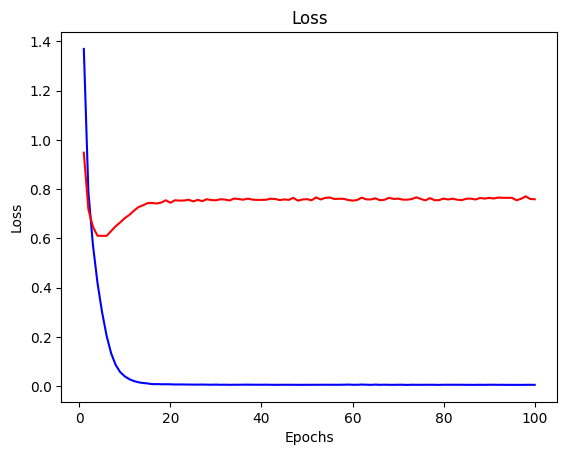

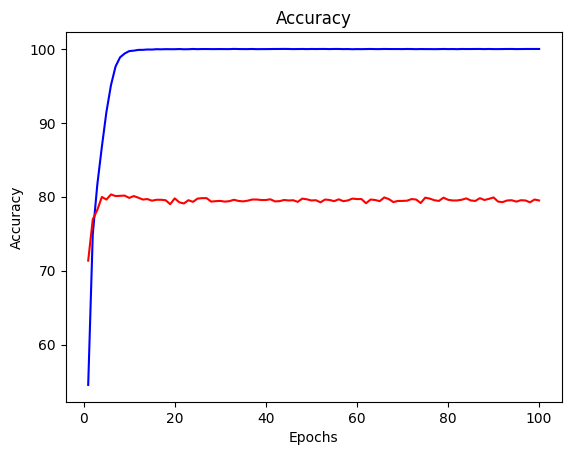

In [12]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Disaster_Types_Classification_ResNet50_pretrained Confusion Matrix:

landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0


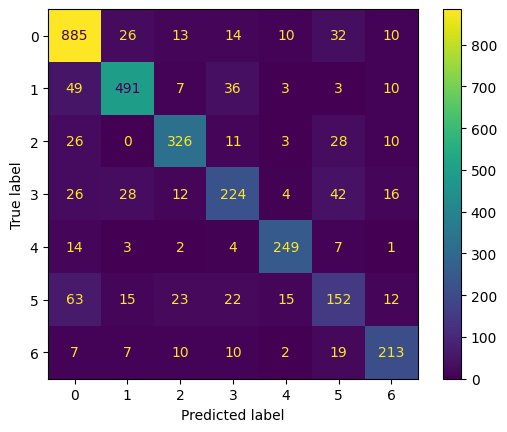

In [13]:
# "landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0
print(task + '_ResNet50_pretrained Confusion Matrix:\n')
print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_pretrained

In [14]:
model = models.efficientnet_b1(weights=models.EfficientNet_B1_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [15]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [16]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [17]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.8689 - accuracy: 26.98% - val_loss: 1.7715 - val_accuracy: 42.38% - time: 39.30s
Epoch 2/100 - loss: 1.6721 - accuracy: 47.89% - val_loss: 1.5783 - val_accuracy: 56.78% - time: 39.12s
Epoch 3/100 - loss: 1.4575 - accuracy: 58.17% - val_loss: 1.3702 - val_accuracy: 62.79% - time: 39.25s
Epoch 4/100 - loss: 1.2648 - accuracy: 63.65% - val_loss: 1.2076 - val_accuracy: 67.01% - time: 39.16s
Epoch 5/100 - loss: 1.1185 - accuracy: 67.69% - val_loss: 1.0801 - val_accuracy: 69.36% - time: 39.12s
Epoch 6/100 - loss: 1.0069 - accuracy: 70.43% - val_loss: 0.9843 - val_accuracy: 71.74% - time: 39.18s
Epoch 7/100 - loss: 0.9202 - accuracy: 72.47% - val_loss: 0.9102 - val_accuracy: 72.99% - time: 39.12s
Epoch 8/100 - loss: 0.8448 - accuracy: 74.49% - val_loss: 0.8486 - val_accuracy: 74.74% - time: 39.24s
Epoch 9/100 - loss: 0.7785 - accuracy: 76.20% - val_loss: 0.7984 - val_accuracy: 75.65% - time: 39.17s
Epoch 10/100 - loss: 0.7233 - accuracy: 77.47% - val_loss: 0.7576 - val_a

Epoch 80/100 - loss: 0.1793 - accuracy: 94.59% - val_loss: 0.5938 - val_accuracy: 80.81% - time: 39.22s
Epoch 81/100 - loss: 0.1832 - accuracy: 94.40% - val_loss: 0.5920 - val_accuracy: 80.85% - time: 39.37s
Epoch 82/100 - loss: 0.1822 - accuracy: 94.33% - val_loss: 0.5918 - val_accuracy: 80.59% - time: 39.16s
Epoch 83/100 - loss: 0.1796 - accuracy: 94.50% - val_loss: 0.5918 - val_accuracy: 80.59% - time: 39.29s
Epoch 84/100 - loss: 0.1774 - accuracy: 94.47% - val_loss: 0.5884 - val_accuracy: 80.94% - time: 39.18s
Epoch 85/100 - loss: 0.1782 - accuracy: 94.61% - val_loss: 0.5945 - val_accuracy: 80.85% - time: 39.20s
Epoch 86/100 - loss: 0.1793 - accuracy: 94.53% - val_loss: 0.5914 - val_accuracy: 80.63% - time: 39.19s
Epoch 87/100 - loss: 0.1818 - accuracy: 94.48% - val_loss: 0.5965 - val_accuracy: 80.63% - time: 39.17s
Epoch 88/100 - loss: 0.1814 - accuracy: 94.50% - val_loss: 0.5933 - val_accuracy: 80.56% - time: 39.16s
Epoch 89/100 - loss: 0.1859 - accuracy: 94.31% - val_loss: 0.591

In [18]:
print(task + '_EfficientNetb1_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_pretrained Classification Report:')
print(cr)

Disaster_Types_Classification_EfficientNetb1_pretrained Performance:
Accuracy : 81.19%
F1-Score : 80.99%
Disaster_Types_Classification_EfficientNetb1_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.88       990
           1       0.86      0.85      0.86       599
           2       0.81      0.83      0.82       404
           3       0.69      0.69      0.69       352
           4       0.86      0.90      0.88       280
           5       0.54      0.48      0.51       302
           6       0.80      0.85      0.82       268

    accuracy                           0.81      3195
   macro avg       0.78      0.78      0.78      3195
weighted avg       0.80      0.81      0.81      3195



## Visualize Results & Confusion Matrix

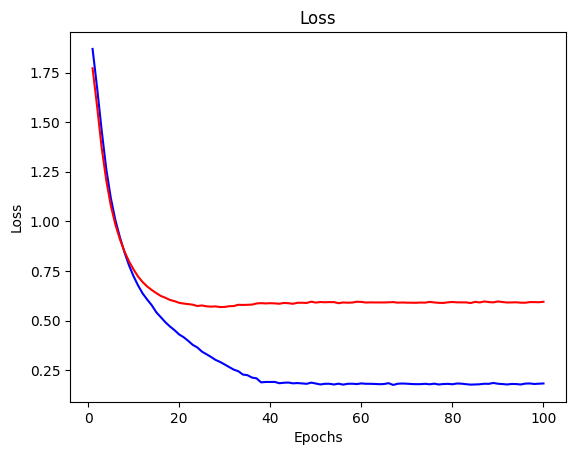

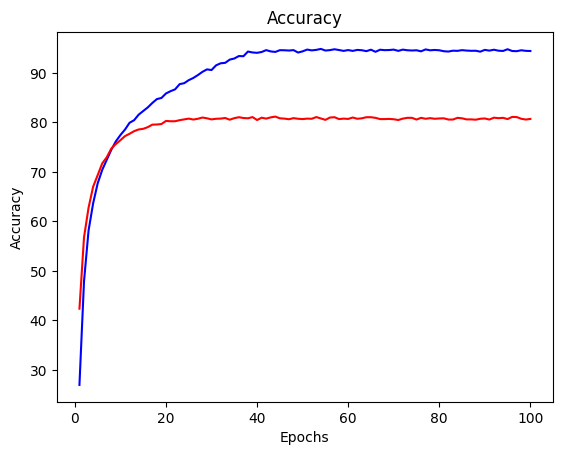

In [19]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Disaster_Types_Classification_EfficientNetb1_pretrained Confusion Matrix:

landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0


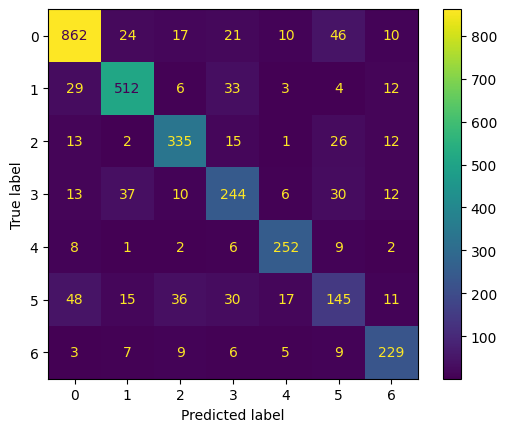

In [20]:
# "landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0
print(task + '_EfficientNetb1_pretrained Confusion Matrix:\n')
print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# VGG16_pretrained

In [21]:
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [22]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [23]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_VGG16_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [24]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.2825 - accuracy: 54.87% - val_loss: 0.8621 - val_accuracy: 71.46% - time: 66.47s
Epoch 2/100 - loss: 0.8189 - accuracy: 72.19% - val_loss: 0.7326 - val_accuracy: 75.99% - time: 66.50s
Epoch 3/100 - loss: 0.6710 - accuracy: 77.34% - val_loss: 0.6773 - val_accuracy: 78.09% - time: 66.27s
Epoch 4/100 - loss: 0.5706 - accuracy: 80.61% - val_loss: 0.6490 - val_accuracy: 78.78% - time: 66.23s
Epoch 5/100 - loss: 0.4883 - accuracy: 83.37% - val_loss: 0.6689 - val_accuracy: 78.50% - time: 66.29s
Epoch 6/100 - loss: 0.4185 - accuracy: 85.79% - val_loss: 0.6424 - val_accuracy: 78.50% - time: 66.20s
Epoch 7/100 - loss: 0.3422 - accuracy: 88.20% - val_loss: 0.6765 - val_accuracy: 78.18% - time: 66.32s
Epoch 8/100 - loss: 0.2813 - accuracy: 90.57% - val_loss: 0.6744 - val_accuracy: 78.56% - time: 66.45s
Epoch 9/100 - loss: 0.2256 - accuracy: 92.49% - val_loss: 0.7153 - val_accuracy: 78.59% - time: 66.39s
Epoch 10/100 - loss: 0.1790 - accuracy: 93.90% - val_loss: 0.7579 - val_a

Epoch 80/100 - loss: 0.0133 - accuracy: 99.63% - val_loss: 1.1819 - val_accuracy: 79.22% - time: 66.34s
Epoch 81/100 - loss: 0.0113 - accuracy: 99.72% - val_loss: 1.1811 - val_accuracy: 79.25% - time: 66.49s
Epoch 82/100 - loss: 0.0111 - accuracy: 99.73% - val_loss: 1.1813 - val_accuracy: 79.25% - time: 66.30s
Epoch 83/100 - loss: 0.0116 - accuracy: 99.75% - val_loss: 1.1813 - val_accuracy: 79.28% - time: 66.24s
Epoch 84/100 - loss: 0.0118 - accuracy: 99.68% - val_loss: 1.1818 - val_accuracy: 79.28% - time: 66.29s
Epoch 85/100 - loss: 0.0122 - accuracy: 99.69% - val_loss: 1.1820 - val_accuracy: 79.25% - time: 66.30s
Epoch 86/100 - loss: 0.0127 - accuracy: 99.63% - val_loss: 1.1822 - val_accuracy: 79.28% - time: 66.32s
Epoch 87/100 - loss: 0.0118 - accuracy: 99.74% - val_loss: 1.1823 - val_accuracy: 79.25% - time: 66.33s
Epoch 88/100 - loss: 0.0106 - accuracy: 99.71% - val_loss: 1.1831 - val_accuracy: 79.28% - time: 66.39s
Epoch 89/100 - loss: 0.0103 - accuracy: 99.74% - val_loss: 1.183

In [25]:
print(task + '_VGG16_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_VGG16_pretrained Classification Report:')
print(cr)

Disaster_Types_Classification_VGG16_pretrained Performance:
Accuracy : 79.34%
F1-Score : 78.90%
Disaster_Types_Classification_VGG16_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       990
           1       0.84      0.84      0.84       599
           2       0.76      0.82      0.79       404
           3       0.67      0.61      0.64       352
           4       0.81      0.89      0.84       280
           5       0.56      0.44      0.49       302
           6       0.79      0.82      0.81       268

    accuracy                           0.79      3195
   macro avg       0.76      0.76      0.76      3195
weighted avg       0.79      0.79      0.79      3195



## Visualize Results & Confusion Matrix

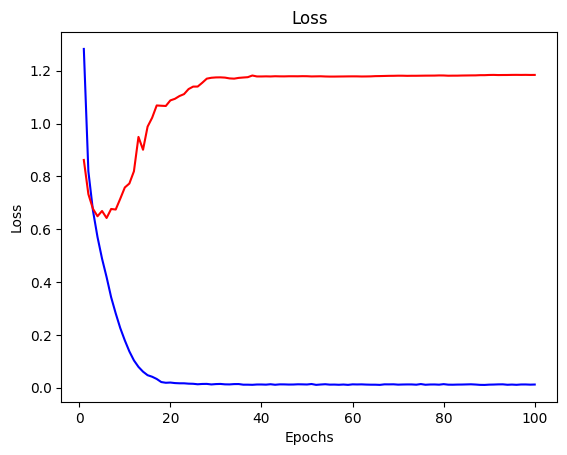

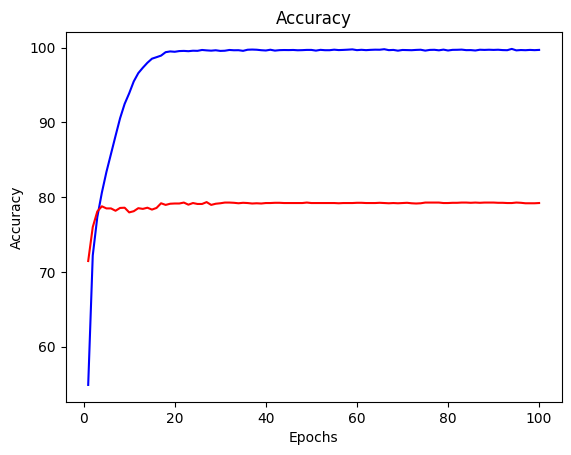

In [26]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Disaster_Types_Classification_VGG16_pretrained Confusion Matrix:

landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0


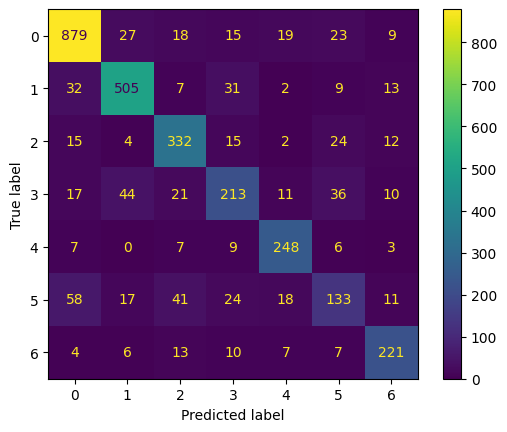

In [27]:
# "landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0
print(task + '_VGG16_pretrained Confusion Matrix:\n')
print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet18_pretrained

In [28]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [29]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [30]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet18_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [31]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.4359 - accuracy: 49.90% - val_loss: 1.0829 - val_accuracy: 66.38% - time: 19.71s
Epoch 2/100 - loss: 0.9222 - accuracy: 70.24% - val_loss: 0.8481 - val_accuracy: 72.86% - time: 19.75s
Epoch 3/100 - loss: 0.7400 - accuracy: 75.59% - val_loss: 0.7589 - val_accuracy: 75.31% - time: 19.56s
Epoch 4/100 - loss: 0.6338 - accuracy: 79.32% - val_loss: 0.7151 - val_accuracy: 76.53% - time: 19.88s
Epoch 5/100 - loss: 0.5496 - accuracy: 82.57% - val_loss: 0.6893 - val_accuracy: 77.56% - time: 19.67s
Epoch 6/100 - loss: 0.4871 - accuracy: 84.78% - val_loss: 0.6651 - val_accuracy: 77.93% - time: 19.69s
Epoch 7/100 - loss: 0.4217 - accuracy: 87.49% - val_loss: 0.6536 - val_accuracy: 78.59% - time: 19.82s
Epoch 8/100 - loss: 0.3703 - accuracy: 89.41% - val_loss: 0.6453 - val_accuracy: 78.50% - time: 19.73s
Epoch 9/100 - loss: 0.3151 - accuracy: 91.55% - val_loss: 0.6418 - val_accuracy: 78.75% - time: 19.72s
Epoch 10/100 - loss: 0.2695 - accuracy: 93.10% - val_loss: 0.6407 - val_a

Epoch 80/100 - loss: 0.0234 - accuracy: 99.95% - val_loss: 0.7334 - val_accuracy: 77.72% - time: 19.60s
Epoch 81/100 - loss: 0.0233 - accuracy: 99.97% - val_loss: 0.7344 - val_accuracy: 77.72% - time: 19.97s
Epoch 82/100 - loss: 0.0237 - accuracy: 99.95% - val_loss: 0.7280 - val_accuracy: 78.37% - time: 19.58s
Epoch 83/100 - loss: 0.0231 - accuracy: 99.98% - val_loss: 0.7316 - val_accuracy: 78.31% - time: 19.67s
Epoch 84/100 - loss: 0.0238 - accuracy: 99.96% - val_loss: 0.7275 - val_accuracy: 78.65% - time: 19.70s
Epoch 85/100 - loss: 0.0243 - accuracy: 99.93% - val_loss: 0.7295 - val_accuracy: 78.12% - time: 19.84s
Epoch 86/100 - loss: 0.0238 - accuracy: 99.95% - val_loss: 0.7273 - val_accuracy: 78.28% - time: 19.80s
Epoch 87/100 - loss: 0.0233 - accuracy: 99.96% - val_loss: 0.7276 - val_accuracy: 78.40% - time: 19.76s
Epoch 88/100 - loss: 0.0240 - accuracy: 99.95% - val_loss: 0.7373 - val_accuracy: 77.65% - time: 19.68s
Epoch 89/100 - loss: 0.0235 - accuracy: 99.98% - val_loss: 0.727

In [32]:
print(task + '_ResNet18_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet18_pretrained Classification Report:')
print(cr)

Disaster_Types_Classification_ResNet18_pretrained Performance:
Accuracy : 79.00%
F1-Score : 78.67%
Disaster_Types_Classification_ResNet18_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.90      0.87       990
           1       0.85      0.80      0.82       599
           2       0.77      0.79      0.78       404
           3       0.65      0.65      0.65       352
           4       0.83      0.88      0.85       280
           5       0.52      0.42      0.47       302
           6       0.81      0.79      0.80       268

    accuracy                           0.78      3195
   macro avg       0.75      0.75      0.75      3195
weighted avg       0.78      0.78      0.78      3195



## Visualize Results & Confusion Matrix

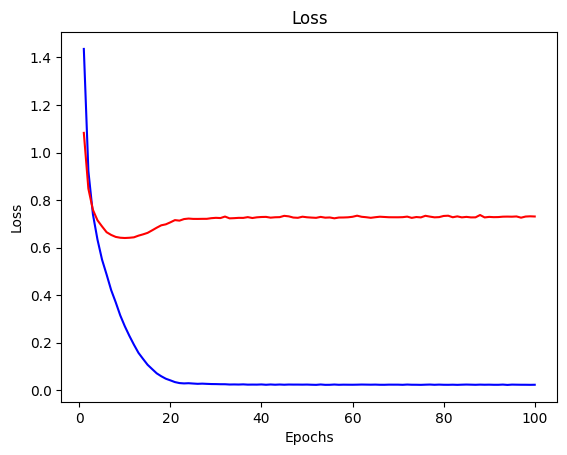

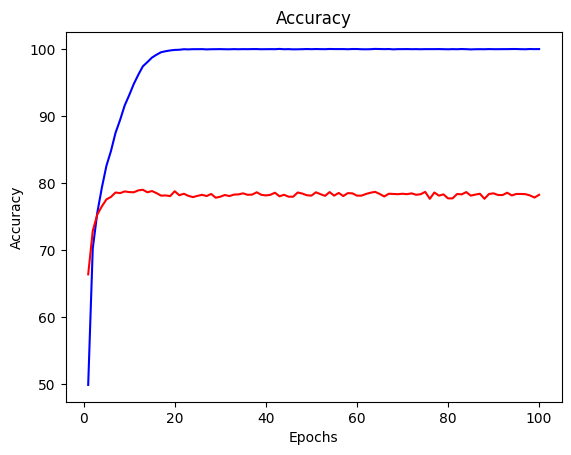

In [33]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Disaster_Types_Classification_ResNet18_pretrained Confusion Matrix:

landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0


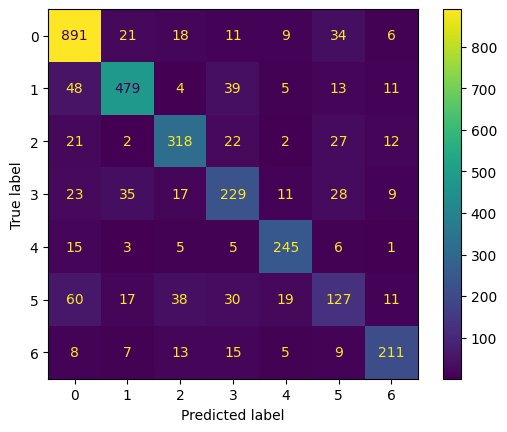

In [34]:
# "landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0
print(task + '_ResNet18_pretrained Confusion Matrix:\n')
print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet101_pretrained

In [35]:
model = models.resnet101(weights=models.ResNet101_Weights.IMAGENET1K_V1)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [36]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [37]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet101_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [38]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.2673 - accuracy: 58.95% - val_loss: 0.8464 - val_accuracy: 73.90% - time: 71.78s
Epoch 2/100 - loss: 0.6800 - accuracy: 78.22% - val_loss: 0.6581 - val_accuracy: 78.44% - time: 71.90s
Epoch 3/100 - loss: 0.4494 - accuracy: 85.90% - val_loss: 0.5986 - val_accuracy: 79.84% - time: 71.83s
Epoch 4/100 - loss: 0.2814 - accuracy: 92.07% - val_loss: 0.6009 - val_accuracy: 79.69% - time: 71.81s
Epoch 5/100 - loss: 0.1633 - accuracy: 96.33% - val_loss: 0.6163 - val_accuracy: 79.78% - time: 71.93s
Epoch 6/100 - loss: 0.0884 - accuracy: 98.52% - val_loss: 0.6350 - val_accuracy: 79.97% - time: 71.82s
Epoch 7/100 - loss: 0.0478 - accuracy: 99.32% - val_loss: 0.6498 - val_accuracy: 79.87% - time: 71.95s
Epoch 8/100 - loss: 0.0280 - accuracy: 99.71% - val_loss: 0.6694 - val_accuracy: 80.09% - time: 71.91s
Epoch 9/100 - loss: 0.0177 - accuracy: 99.85% - val_loss: 0.6897 - val_accuracy: 79.97% - time: 71.90s
Epoch 10/100 - loss: 0.0124 - accuracy: 99.91% - val_loss: 0.7125 - val_a

Epoch 80/100 - loss: 0.0028 - accuracy: 99.99% - val_loss: 0.7707 - val_accuracy: 80.19% - time: 71.99s
Epoch 81/100 - loss: 0.0029 - accuracy: 99.99% - val_loss: 0.7728 - val_accuracy: 79.69% - time: 72.00s
Epoch 82/100 - loss: 0.0031 - accuracy: 99.98% - val_loss: 0.7748 - val_accuracy: 80.06% - time: 71.90s
Epoch 83/100 - loss: 0.0029 - accuracy: 100.00% - val_loss: 0.7758 - val_accuracy: 79.69% - time: 71.84s
Epoch 84/100 - loss: 0.0032 - accuracy: 99.97% - val_loss: 0.7723 - val_accuracy: 80.34% - time: 71.84s
Epoch 85/100 - loss: 0.0031 - accuracy: 99.98% - val_loss: 0.7729 - val_accuracy: 79.87% - time: 71.92s
Epoch 86/100 - loss: 0.0031 - accuracy: 99.97% - val_loss: 0.7714 - val_accuracy: 79.87% - time: 71.85s
Epoch 87/100 - loss: 0.0031 - accuracy: 99.97% - val_loss: 0.7712 - val_accuracy: 79.78% - time: 71.99s
Epoch 88/100 - loss: 0.0030 - accuracy: 99.98% - val_loss: 0.7700 - val_accuracy: 79.84% - time: 71.82s
Epoch 89/100 - loss: 0.0031 - accuracy: 99.99% - val_loss: 0.77

In [39]:
print(task + '_ResNet101_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet101_pretrained Classification Report:')
print(cr)

Disaster_Types_Classification_ResNet101_pretrained Performance:
Accuracy : 80.34%
F1-Score : 79.98%
Disaster_Types_Classification_ResNet101_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.88       990
           1       0.85      0.85      0.85       599
           2       0.77      0.80      0.79       404
           3       0.70      0.66      0.68       352
           4       0.85      0.89      0.87       280
           5       0.52      0.43      0.47       302
           6       0.80      0.80      0.80       268

    accuracy                           0.80      3195
   macro avg       0.76      0.76      0.76      3195
weighted avg       0.79      0.80      0.79      3195



## Visualize Results & Confusion Matrix

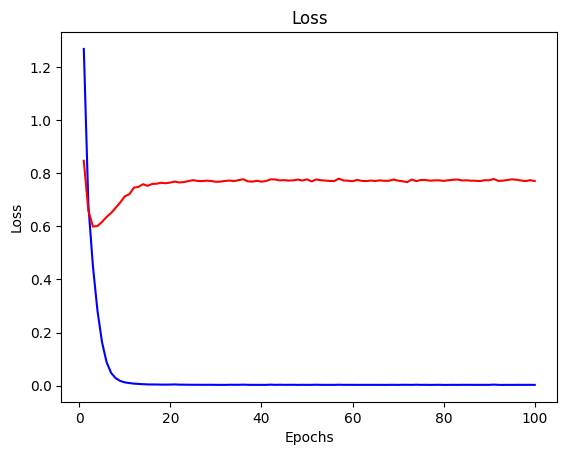

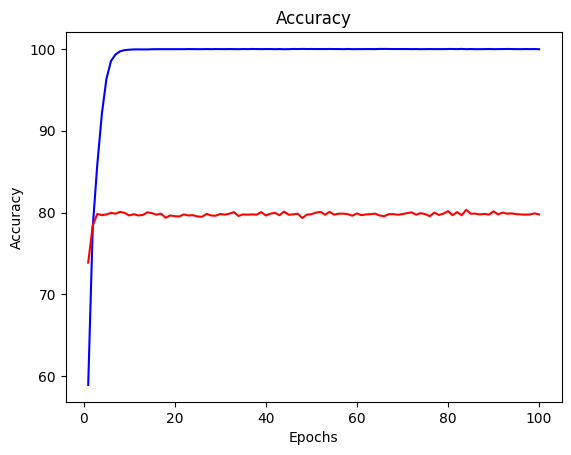

In [40]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Disaster_Types_Classification_ResNet101_pretrained Confusion Matrix:

landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0


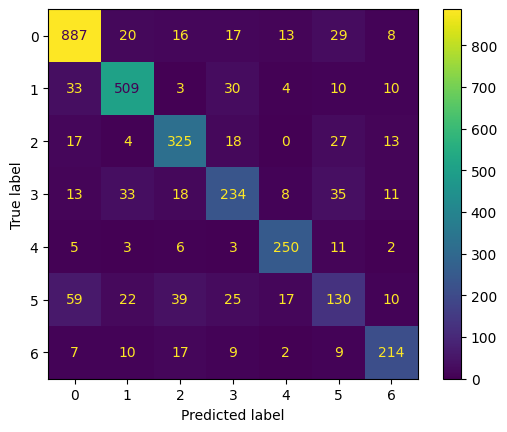

In [41]:
# "landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0
print(task + '_ResNet101_pretrained Confusion Matrix:\n')
print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# DenseNet121_pretrained

In [42]:
model = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs = model.classifier.in_features
model.classifier = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=10)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [43]:
# Learning schedule update
def dev_one_epoch(dev_data_loader):
    epoch_loss = []
    epoch_acc = []

    model.eval()

    with torch.no_grad():
        for images, labels in dev_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)  # Forward

            # Calculating Loss
            _loss = criterion(preds, labels)
            loss = _loss.item()
            epoch_loss.append(loss)

            # Calculating Accuracy
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            epoch_acc.append(acc)

    # Acc and Loss
    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc)

    return epoch_loss, epoch_acc

In [44]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_DenseNet121_pretrained.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [45]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    dev_loss, dev_acc = dev_one_epoch(devloader) # Dev
    lr_scheduler.step(dev_loss)
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/100 - loss: 1.6286 - accuracy: 42.36% - val_loss: 1.3110 - val_accuracy: 61.97% - time: 51.29s
Epoch 2/100 - loss: 1.1120 - accuracy: 66.43% - val_loss: 0.9897 - val_accuracy: 70.49% - time: 51.15s
Epoch 3/100 - loss: 0.8719 - accuracy: 73.20% - val_loss: 0.8438 - val_accuracy: 74.15% - time: 51.07s
Epoch 4/100 - loss: 0.7356 - accuracy: 77.34% - val_loss: 0.7617 - val_accuracy: 75.99% - time: 51.34s
Epoch 5/100 - loss: 0.6419 - accuracy: 80.10% - val_loss: 0.7067 - val_accuracy: 77.31% - time: 51.26s
Epoch 6/100 - loss: 0.5720 - accuracy: 82.29% - val_loss: 0.6781 - val_accuracy: 77.68% - time: 51.20s
Epoch 7/100 - loss: 0.5095 - accuracy: 84.42% - val_loss: 0.6494 - val_accuracy: 78.69% - time: 51.01s
Epoch 8/100 - loss: 0.4555 - accuracy: 86.16% - val_loss: 0.6355 - val_accuracy: 78.59% - time: 51.23s
Epoch 9/100 - loss: 0.4082 - accuracy: 88.12% - val_loss: 0.6241 - val_accuracy: 78.90% - time: 51.09s
Epoch 10/100 - loss: 0.3606 - accuracy: 89.93% - val_loss: 0.6148 - val_a

Epoch 80/100 - loss: 0.0329 - accuracy: 99.66% - val_loss: 0.7230 - val_accuracy: 78.37% - time: 51.14s
Epoch 81/100 - loss: 0.0322 - accuracy: 99.67% - val_loss: 0.7244 - val_accuracy: 78.40% - time: 51.24s
Epoch 82/100 - loss: 0.0319 - accuracy: 99.67% - val_loss: 0.7238 - val_accuracy: 78.28% - time: 51.11s
Epoch 83/100 - loss: 0.0329 - accuracy: 99.67% - val_loss: 0.7225 - val_accuracy: 78.09% - time: 51.09s
Epoch 84/100 - loss: 0.0316 - accuracy: 99.68% - val_loss: 0.7228 - val_accuracy: 77.81% - time: 51.14s
Epoch 85/100 - loss: 0.0327 - accuracy: 99.68% - val_loss: 0.7245 - val_accuracy: 78.18% - time: 51.23s
Epoch 86/100 - loss: 0.0323 - accuracy: 99.60% - val_loss: 0.7234 - val_accuracy: 78.40% - time: 51.08s
Epoch 87/100 - loss: 0.0334 - accuracy: 99.66% - val_loss: 0.7230 - val_accuracy: 78.34% - time: 51.01s
Epoch 88/100 - loss: 0.0329 - accuracy: 99.61% - val_loss: 0.7256 - val_accuracy: 78.34% - time: 51.23s
Epoch 89/100 - loss: 0.0323 - accuracy: 99.65% - val_loss: 0.721

In [46]:
print(task + '_DenseNet121_pretrained Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_DenseNet121_pretrained Classification Report:')
print(cr)

Disaster_Types_Classification_DenseNet121_pretrained Performance:
Accuracy : 79.15%
F1-Score : 78.70%
Disaster_Types_Classification_DenseNet121_pretrained Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.89      0.87       990
           1       0.83      0.82      0.83       599
           2       0.80      0.82      0.81       404
           3       0.67      0.59      0.62       352
           4       0.80      0.86      0.83       280
           5       0.51      0.44      0.47       302
           6       0.78      0.78      0.78       268

    accuracy                           0.78      3195
   macro avg       0.75      0.74      0.75      3195
weighted avg       0.78      0.78      0.78      3195



## Visualize Results & Confusion Matrix

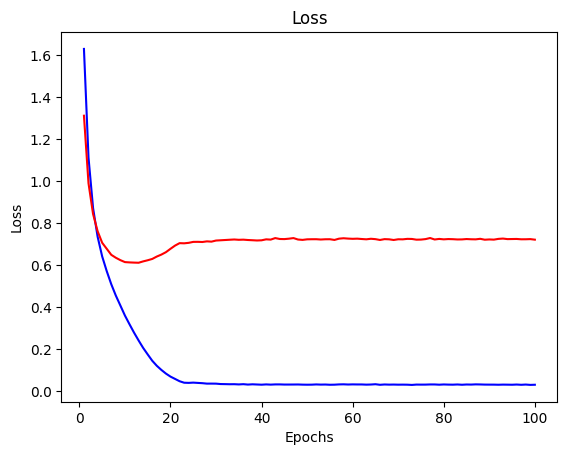

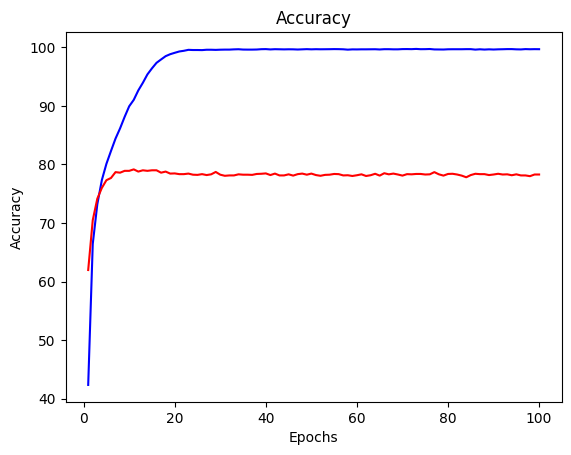

In [47]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Disaster_Types_Classification_DenseNet121_pretrained Confusion Matrix:

landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0


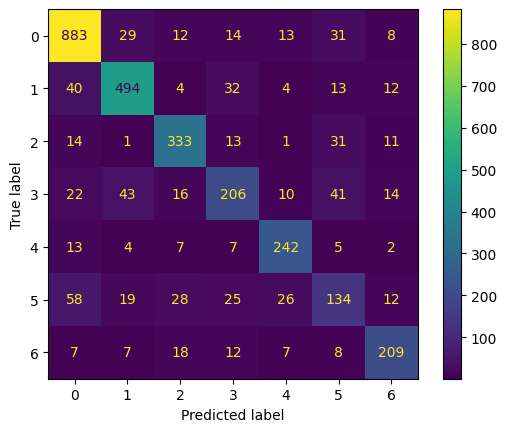

In [48]:
# "landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0
print(task + '_DenseNet121_pretrained Confusion Matrix:\n')
print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# ResNet50_scratch

In [7]:
model = models.resnet50(weights=None)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [8]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_ResNet50_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [9]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/200 - loss: 4.1026 - accuracy: 26.72% - val_loss: 1.8311 - val_accuracy: 30.99% - time: 45.73s
Epoch 2/200 - loss: 1.9440 - accuracy: 28.49% - val_loss: 8.6701 - val_accuracy: 19.25% - time: 45.09s
Epoch 3/200 - loss: 1.8975 - accuracy: 27.88% - val_loss: 1.8154 - val_accuracy: 31.11% - time: 45.22s
Epoch 4/200 - loss: 1.8293 - accuracy: 30.48% - val_loss: 1.7857 - val_accuracy: 33.30% - time: 45.09s
Epoch 5/200 - loss: 1.7476 - accuracy: 33.68% - val_loss: 1.7680 - val_accuracy: 34.74% - time: 45.16s
Epoch 6/200 - loss: 1.7132 - accuracy: 35.84% - val_loss: 1.7693 - val_accuracy: 30.08% - time: 45.23s
Epoch 7/200 - loss: 1.6608 - accuracy: 38.43% - val_loss: 1.7396 - val_accuracy: 36.53% - time: 45.08s
Epoch 8/200 - loss: 1.6171 - accuracy: 40.38% - val_loss: 1.6338 - val_accuracy: 38.69% - time: 45.14s
Epoch 9/200 - loss: 1.5791 - accuracy: 41.82% - val_loss: 1.6872 - val_accuracy: 36.18% - time: 45.25s
Epoch 10/200 - loss: 1.5390 - accuracy: 43.53% - val_loss: 1.5023 - val_a

Epoch 80/200 - loss: 0.1951 - accuracy: 93.18% - val_loss: 2.5992 - val_accuracy: 49.17% - time: 45.25s
Epoch 81/200 - loss: 0.1787 - accuracy: 93.95% - val_loss: 2.3615 - val_accuracy: 48.23% - time: 45.43s
Epoch 82/200 - loss: 0.1547 - accuracy: 94.74% - val_loss: 2.3339 - val_accuracy: 51.46% - time: 45.47s
Epoch 83/200 - loss: 0.2050 - accuracy: 93.08% - val_loss: 2.2919 - val_accuracy: 49.11% - time: 45.41s
Epoch 84/200 - loss: 0.1732 - accuracy: 94.04% - val_loss: 2.5386 - val_accuracy: 52.33% - time: 45.33s
Epoch 85/200 - loss: 0.1736 - accuracy: 93.97% - val_loss: 2.5099 - val_accuracy: 52.68% - time: 45.35s
Epoch 86/200 - loss: 0.1735 - accuracy: 94.00% - val_loss: 2.6298 - val_accuracy: 47.29% - time: 45.30s
Epoch 87/200 - loss: 0.1692 - accuracy: 94.20% - val_loss: 2.4304 - val_accuracy: 55.09% - time: 45.23s
Epoch 88/200 - loss: 0.1762 - accuracy: 94.18% - val_loss: 2.9147 - val_accuracy: 46.13% - time: 45.25s
Epoch 89/200 - loss: 0.1418 - accuracy: 95.34% - val_loss: 2.844

Epoch 159/200 - loss: 0.1338 - accuracy: 95.70% - val_loss: 2.3943 - val_accuracy: 52.64% - time: 45.33s
Epoch 160/200 - loss: 0.1344 - accuracy: 95.59% - val_loss: 3.2191 - val_accuracy: 46.51% - time: 45.58s
Epoch 161/200 - loss: 0.1670 - accuracy: 94.38% - val_loss: 3.7126 - val_accuracy: 40.56% - time: 45.30s
Epoch 162/200 - loss: 0.1593 - accuracy: 94.44% - val_loss: 2.5650 - val_accuracy: 49.92% - time: 45.30s
Epoch 163/200 - loss: 0.1311 - accuracy: 95.83% - val_loss: 2.7458 - val_accuracy: 52.02% - time: 45.42s
Epoch 164/200 - loss: 0.0901 - accuracy: 97.25% - val_loss: 2.2937 - val_accuracy: 50.49% - time: 45.45s
Epoch 165/200 - loss: 0.0787 - accuracy: 97.62% - val_loss: 2.4601 - val_accuracy: 50.92% - time: 45.49s
Epoch 166/200 - loss: 0.0950 - accuracy: 97.21% - val_loss: 2.5918 - val_accuracy: 45.95% - time: 45.37s
Epoch 167/200 - loss: 0.2110 - accuracy: 92.58% - val_loss: 3.2172 - val_accuracy: 46.01% - time: 45.32s
Epoch 168/200 - loss: 0.2135 - accuracy: 92.68% - val_l

In [10]:
print(task + '_ResNet50_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_ResNet50_scratch Classification Report:')
print(cr)

Disaster_Types_Classification_ResNet50_scratch Performance:
Accuracy : 55.08%
F1-Score : 54.06%
Disaster_Types_Classification_ResNet50_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.80      0.66       990
           1       0.55      0.47      0.51       599
           2       0.56      0.25      0.35       404
           3       0.27      0.53      0.35       352
           4       0.54      0.43      0.48       280
           5       0.27      0.09      0.13       302
           6       0.90      0.14      0.24       268

    accuracy                           0.49      3195
   macro avg       0.52      0.39      0.39      3195
weighted avg       0.52      0.49      0.46      3195



## Visualize Results & Confusion Matrix

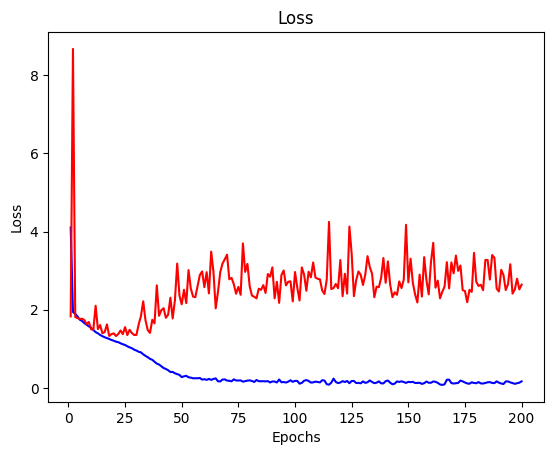

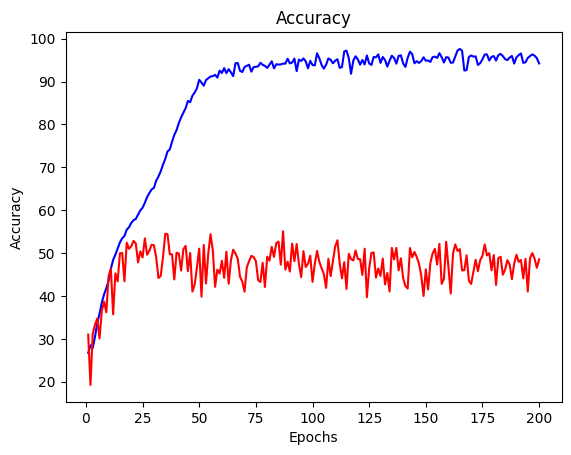

In [11]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Disaster_Types_Classification_ResNet50_scratch Confusion Matrix:

landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0


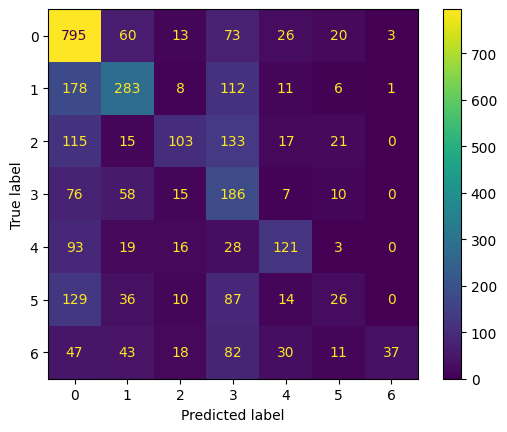

In [12]:
# "landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0
print(task + '_ResNet50_scratch Confusion Matrix:\n')
print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()

# EfficientNetb1_scratch

In [13]:
model = models.efficientnet_b1(weights=None)
num_ftrs = model.classifier[-1].in_features
model.classifier[-1] = nn.Linear(num_ftrs, len(class_label_map))
model = model.to(device)

optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4, nesterov=True)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[60, 120, 160], gamma=0.2)
criterion = nn.CrossEntropyLoss()

train_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}
val_logs = {"loss": [], "accuracy": [], "acc": [], "f1": [], "f1-score": [], "time": []}

## Train

In [14]:
def train_one_epoch(train_data_loader):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.train()

    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        preds = model(images)

        # Calculating Loss
        loss = criterion(preds, labels)
        epoch_loss.append(loss.item())

        # Calculating Metrics
        _, predicts = preds.max(1)
        predicts = predicts.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        acc = accuracy_score(labels, predicts)
        f1 = f1_score(labels, predicts, average="weighted")
        epoch_acc.append(acc)
        epoch_f1.append(f1)
        trues.append(labels)
        prediction.append(predicts)

        # Backpropagation
        loss.backward()
        optimizer.step()

    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    train_logs["loss"].append(epoch_loss)
    train_logs["accuracy"].append(accuracy)
    train_logs["acc"].append(epoch_acc) # check
    train_logs["f1"].append(epoch_f1) # check
    train_logs["f1-score"].append(f1score)
    train_logs["time"].append(total_time)

    return epoch_loss, accuracy, f1score, total_time

def val_one_epoch(val_data_loader, best_val_acc):
    epoch_loss = []
    epoch_acc = []
    epoch_f1 = []
    trues = []
    prediction = []
    start_time = time.time()

    model.eval()

    with torch.no_grad():
        for images, labels in val_data_loader:
            images = images.to(device)
            labels = labels.to(device)

            preds = model(images)

            # Calculating Loss
            loss = criterion(preds, labels)
            epoch_loss.append(loss.item())

            # Calculating Metrics
            _, predicts = preds.max(1)
            predicts = predicts.detach().cpu().numpy()
            labels = labels.detach().cpu().numpy()
            acc = accuracy_score(labels, predicts)
            f1 = f1_score(labels, predicts, average="weighted")
            epoch_acc.append(acc)
            epoch_f1.append(f1)
            trues.append(labels)
            prediction.append(predicts)
   
    
    trues = np.concatenate(trues)
    prediction = np.concatenate(prediction)
    cm = confusion_matrix(trues, prediction)
    accuracy = accuracy_score(trues, prediction)
    f1score = f1_score(trues, prediction, average="weighted")
    accuracy = accuracy * 100
    f1score = f1score * 100
    cr = classification_report(trues, prediction)

    # Overall Epoch Results
    end_time = time.time()
    total_time = end_time - start_time

    epoch_loss = np.mean(epoch_loss)
    epoch_acc = np.mean(epoch_acc) * 100
    epoch_f1 = np.mean(epoch_f1) * 100

    val_logs["loss"].append(epoch_loss)
    val_logs["accuracy"].append(accuracy)
    val_logs["acc"].append(epoch_acc) # check
    val_logs["f1"].append(epoch_f1) # check
    val_logs["f1-score"].append(f1score)
    val_logs["time"].append(total_time)

    # Saving best model
    if epoch_acc > best_val_acc:
        best_val_acc = epoch_acc
        torch.save(model.state_dict(), task + "_EfficientNetb1_scratch.pth")

    return epoch_loss, accuracy, f1score, total_time, best_val_acc, cm, cr

In [15]:
best_val_acc = 0
best_val_f1 = 0

for epoch in range(epochs):
    train_loss, train_acc, train_f1, train_time = train_one_epoch(trainloader) # Training
    val_loss, val_acc, val_f1, val_time, best_val_acc, cm, cr = val_one_epoch(testloader, best_val_acc) # Validation
    lr_scheduler.step(val_loss)

    if val_f1 > best_val_f1:
        best_val_f1 = val_f1

    total_time = train_time + val_time
    print(f"Epoch {epoch+1}/{epochs} - loss: {train_loss:.4f} - accuracy: {train_acc:.2f}% - val_loss: {val_loss:.4f} - val_accuracy: {val_acc:.2f}% - time: {total_time:.2f}s")

Epoch 1/200 - loss: 1.9758 - accuracy: 28.79% - val_loss: 1.7735 - val_accuracy: 33.24% - time: 38.08s
Epoch 2/200 - loss: 1.7411 - accuracy: 34.23% - val_loss: 1.7664 - val_accuracy: 33.77% - time: 38.07s
Epoch 3/200 - loss: 1.6714 - accuracy: 36.52% - val_loss: 1.6870 - val_accuracy: 34.90% - time: 37.97s
Epoch 4/200 - loss: 1.5753 - accuracy: 41.83% - val_loss: 1.5663 - val_accuracy: 42.00% - time: 38.04s
Epoch 5/200 - loss: 1.4842 - accuracy: 45.91% - val_loss: 1.5050 - val_accuracy: 45.82% - time: 37.93s
Epoch 6/200 - loss: 1.4108 - accuracy: 49.34% - val_loss: 1.6510 - val_accuracy: 40.94% - time: 37.95s
Epoch 7/200 - loss: 1.3676 - accuracy: 50.90% - val_loss: 1.4759 - val_accuracy: 46.73% - time: 38.03s
Epoch 8/200 - loss: 1.3046 - accuracy: 53.09% - val_loss: 1.4602 - val_accuracy: 47.98% - time: 37.98s
Epoch 9/200 - loss: 1.2664 - accuracy: 54.91% - val_loss: 1.5210 - val_accuracy: 44.82% - time: 38.20s
Epoch 10/200 - loss: 1.2317 - accuracy: 56.13% - val_loss: 1.4543 - val_a

Epoch 80/200 - loss: 0.4284 - accuracy: 85.01% - val_loss: 1.7962 - val_accuracy: 53.43% - time: 38.28s
Epoch 81/200 - loss: 0.4371 - accuracy: 84.60% - val_loss: 1.7663 - val_accuracy: 54.77% - time: 38.11s
Epoch 82/200 - loss: 0.4272 - accuracy: 85.05% - val_loss: 1.6975 - val_accuracy: 58.25% - time: 38.07s
Epoch 83/200 - loss: 0.4254 - accuracy: 85.11% - val_loss: 1.7473 - val_accuracy: 54.87% - time: 38.23s
Epoch 84/200 - loss: 0.4463 - accuracy: 83.92% - val_loss: 1.8834 - val_accuracy: 50.92% - time: 38.07s
Epoch 85/200 - loss: 0.3924 - accuracy: 86.35% - val_loss: 1.5891 - val_accuracy: 56.78% - time: 38.04s
Epoch 86/200 - loss: 0.4148 - accuracy: 85.43% - val_loss: 1.6219 - val_accuracy: 56.87% - time: 38.23s
Epoch 87/200 - loss: 0.3861 - accuracy: 86.24% - val_loss: 1.6731 - val_accuracy: 57.12% - time: 38.18s
Epoch 88/200 - loss: 0.4084 - accuracy: 85.54% - val_loss: 1.5958 - val_accuracy: 57.68% - time: 38.11s
Epoch 89/200 - loss: 0.4051 - accuracy: 85.54% - val_loss: 1.696

Epoch 159/200 - loss: 0.3537 - accuracy: 87.50% - val_loss: 1.8123 - val_accuracy: 54.49% - time: 37.98s
Epoch 160/200 - loss: 0.3010 - accuracy: 89.38% - val_loss: 1.9881 - val_accuracy: 54.15% - time: 38.00s
Epoch 161/200 - loss: 0.3154 - accuracy: 88.92% - val_loss: 2.3523 - val_accuracy: 51.55% - time: 37.95s
Epoch 162/200 - loss: 0.3100 - accuracy: 88.75% - val_loss: 1.9929 - val_accuracy: 52.83% - time: 38.08s
Epoch 163/200 - loss: 0.3144 - accuracy: 89.11% - val_loss: 1.7941 - val_accuracy: 55.21% - time: 38.01s
Epoch 164/200 - loss: 0.3281 - accuracy: 88.43% - val_loss: 1.6041 - val_accuracy: 59.66% - time: 38.06s
Epoch 165/200 - loss: 0.2953 - accuracy: 89.51% - val_loss: 1.9977 - val_accuracy: 54.33% - time: 37.97s
Epoch 166/200 - loss: 0.3263 - accuracy: 88.57% - val_loss: 1.7946 - val_accuracy: 57.34% - time: 38.23s
Epoch 167/200 - loss: 0.3208 - accuracy: 88.78% - val_loss: 1.9720 - val_accuracy: 53.24% - time: 38.05s
Epoch 168/200 - loss: 0.3102 - accuracy: 89.10% - val_l

In [16]:
print(task + '_EfficientNetb1_scratch Performance:')
print(f'Accuracy : {best_val_acc:.2f}%')
print(f'F1-Score : {best_val_f1:.2f}%')
print(task + '_EfficientNetb1_scratch Classification Report:')
print(cr)

Disaster_Types_Classification_EfficientNetb1_scratch Performance:
Accuracy : 62.72%
F1-Score : 61.81%
Disaster_Types_Classification_EfficientNetb1_scratch Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.67      0.62       990
           1       0.70      0.45      0.55       599
           2       0.46      0.30      0.36       404
           3       0.26      0.44      0.32       352
           4       0.62      0.55      0.58       280
           5       0.17      0.25      0.20       302
           6       0.72      0.29      0.42       268

    accuracy                           0.47      3195
   macro avg       0.50      0.42      0.44      3195
weighted avg       0.53      0.47      0.48      3195



## Visualize Results & Confusion Matrix

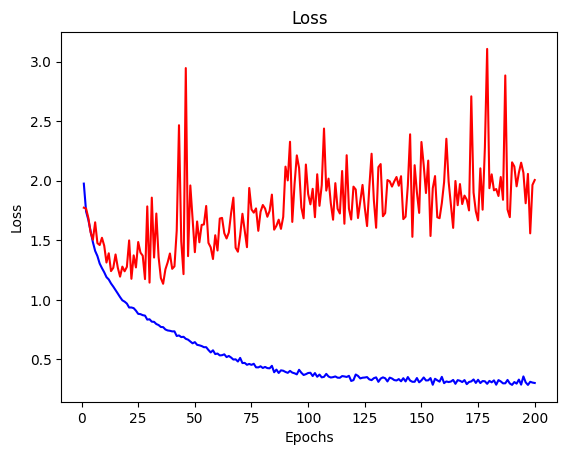

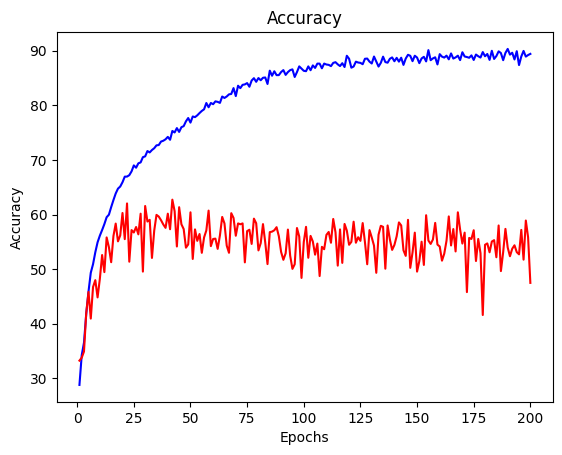

In [17]:
# Loss
plt.title("Loss")
plt.plot(np.arange(1, epochs+1, 1), train_logs["loss"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["loss"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

# Accuracy
plt.title("Accuracy")
plt.plot(np.arange(1, epochs+1, 1), train_logs["accuracy"], color = 'blue')
plt.plot(np.arange(1, epochs+1, 1), val_logs["accuracy"], color = 'red')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()

Disaster_Types_Classification_EfficientNetb1_scratch Confusion Matrix:

landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0


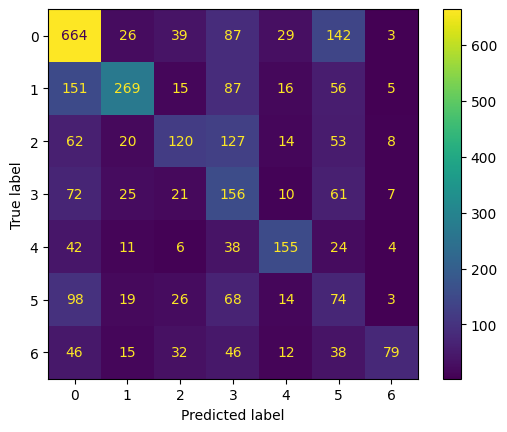

In [18]:
# "landslide":6, "other_disaster":5, "fire":4, "hurricane":3, "earthquake":2, "flood":1, "not_disaster":0
print(task + '_EfficientNetb1_scratch Confusion Matrix:\n')
print('landslide: 6, other_disaster: 5, fire :4, hurricane: 3, earthquake: 2, flood: 1, not_disaster: 0')
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=None)
disp.plot()
plt.show()